In [1]:
data_cdf = "model_results/test_do_transect.nc"

transect_shp = "gis/transect_sjf_thru_puget_sound.shp"
variable = "controlDOXG"
start_date = "2014-01-01"

# TODO:
# - transect name
# - location labels along the transect

from pathlib import Path
from os import path
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.animation as animation
#%matplotlib widget
%matplotlib inline

In [2]:
data = Dataset(data_cdf)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(216), node(236), siglay(10)
    variables(dimensions): int32 node(node), float32 time(time), float32 siglay(siglay), float32 zeta(time, node), float32 controlDOXG(time, siglay, node)
    groups: 

In [3]:
timestep = data['time'][2] - data['time'][1]
timestep

0.04166667

In [4]:
out_base = Path(data_cdf).stem
transect_base = Path(transect_shp).stem
out_file = lambda name: path.join("notebook_outs", out_base + "_" + transect_base + "_" + name)

In [5]:
transect = gpd.read_file(transect_shp)
transect.set_index('node_id', inplace=True)
transect.head()

,depth,geometry
node_id,,
1159,257.800720,POINT (374011.682 5370035.740)
1252,191.153000,POINT (377292.015 5370100.970)
1339,191.626007,POINT (380243.734 5368997.670)
1338,191.858002,POINT (383314.237 5367358.850)
1423,185.763000,POINT (386738.325 5366096.140)


In [6]:
# Calculate the distance between adjacent nodes in the transect
transect['distance'] = transect['geometry'][1:].distance(transect['geometry'][:-1], align=False)
# Set the first one to zero since it's currently NaN
transect.loc[transect.index == transect.index[0], 'distance'] = 0
# Transform into a running total in km
transect['distance'] = transect['distance'].cumsum() / 1000
transect.head()

,depth,geometry,distance
node_id,,,
1159,257.800720,POINT (374011.682 5370035.740),0.000000
1252,191.153000,POINT (377292.015 5370100.970),3.280981
1339,191.626007,POINT (380243.734 5368997.670),6.432158
1338,191.858002,POINT (383314.237 5367358.850),9.912635
1423,185.763000,POINT (386738.325 5366096.140),13.562131


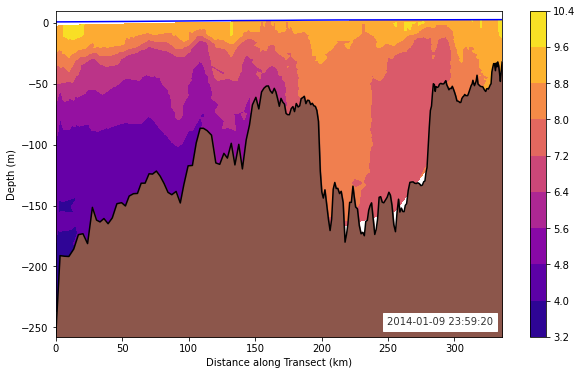

In [7]:
mycmap = 'plasma'

fig, ax = plt.subplots(figsize=(10,6))
# Draw the submerged earth
ax.fill_between(transect['distance'], -1 * transect['depth'].max(),
                -1 * transect['depth'], color='tab:brown', zorder=2)
# Give a nice line for the bottom
ax.plot(transect['distance'], -1 * transect['depth'], 'k', zorder=3)
ax.set(xbound=(0, transect['distance'].max()), ybound=(-1 * transect['depth'].max(), 10),
       xlabel="Distance along Transect (km)", ylabel="Depth (m)")
node_indices = np.searchsorted(data['node'][:], transect.index.to_numpy())
dates = pd.Timestamp(start_date) + pd.to_timedelta(data['time'][:], 'd')
date_text = ax.text(transect['distance'].max() - 0.02 * (transect['distance'].max() -
                                                        transect['distance'].min()),
                    -1 * transect['depth'].max() + 10, dates[0].strftime("%Y-%m-%d %X"),
                    backgroundcolor='w', alpha=0.8, ha='right', va='baseline')

all_vals = data[variable][:,:, node_indices]
norm = colors.Normalize(all_vals.min(), all_vals.max())

sfc = None
tcf = None
colorbar = None

def animate(t):
    global sfc, tcf, cbar_ax, fig, colorbar
    zetas = data['zeta'][t, node_indices]
    if sfc is None:
        sfc, = ax.plot(transect['distance'], zetas, 'b')
    else:
        sfc.set_data(transect['distance'], zetas)
    artists = [sfc]
    # Take the difference of the water surface elevations (zetas) and the depths
    # (transect['depth']) at each point to get the thickness of the water column.
    # Multiply this by the sigma layer depth fractions to get the z value that
    # corresponds to each layer at each node, with some linear algebra needed to
    # make the multiplication and final array dimensions work out how we want
    zs = (transect['depth'].to_numpy() - zetas)[np.newaxis].T * data['siglay'][:]
    # Offset z by the tide height (the adjusted zero point)
    zs += zetas[np.newaxis].T

    # Repeat the distances to get matching x coordinates for the z's
    xs = np.repeat(transect['distance'].to_numpy(), zs.shape[1])
    xs.shape # (2360,)

    vals = data[variable][t, :, node_indices].T.flatten()
    if tcf is not None:
        for c in tcf.collections:
            c.remove()
    tcf = ax.tricontourf(xs, zs.data.flatten(), vals, cmap=mycmap)
    artists += tcf.collections
    if colorbar is None:
        colorbar = fig.colorbar(tcf)
        artists += colorbar.lines
    ax.set(xbound=(0, transect['distance'].max()), ybound=(-1 * transect['depth'].max(), 10))
    date_text.set_text(dates[t].strftime("%Y-%m-%d %X"))
    return artists

anim = animation.FuncAnimation(fig, animate, data['time'].size, blit=True)
anim.save(out_file("{0}.mp4".format(variable)))